<a href="https://colab.research.google.com/github/nh0875/Me/blob/main/Proyecto_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico nro 1 de AA2.

**Juan Ignacio Hilliard Bochaca**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision import datasets, transforms


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
dataset = MNISTSubset(train=True, transform=transform, target_classes=[2, 4])


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.35MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




# Preparacion de los Datos
Dividimos en entrenamiento y prueba, y creamos los DataLoaders para alimentar la red. Esto nos permite manejar lotes (batches) de datos para entrenar más rápido y evitar cargar todo en memoria de golpe

### 3.1 Cargue los datos, divida los conjuntos de datos

In [ ]:
# Dividimos en train (80%) y validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataset de test
test_dataset = MNISTSubset(train=False, transform=transform, target_classes=[2, 4])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tamaño del dataset total: 11800
Tamaño train: 9440
Tamaño validación: 2360
Tamaño test: 2014


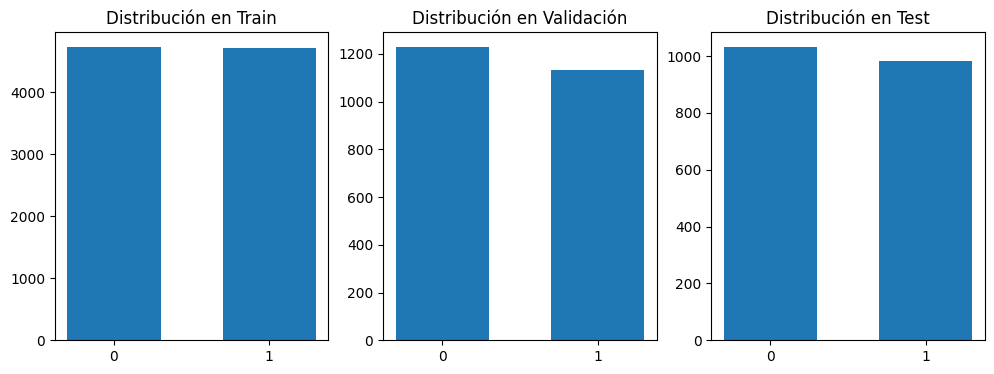

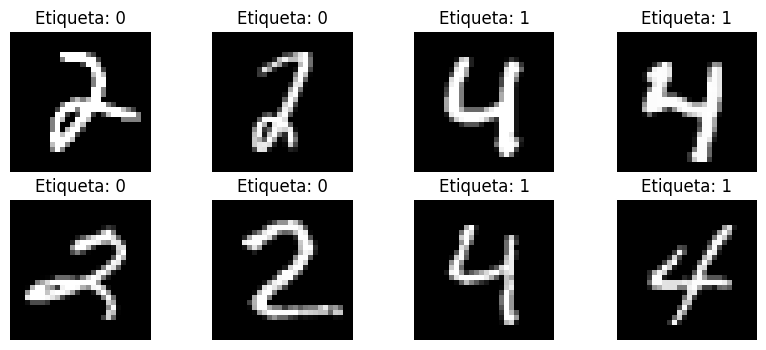

In [ ]:
import matplotlib.pyplot as plt

# Cantidad total de ejemplos
print("Tamaño del dataset total:", len(dataset))
print("Tamaño train:", len(train_dataset))
print("Tamaño validación:", len(val_dataset))
print("Tamaño test:", len(test_dataset))

# Distribución de clases en train y test
train_labels = [dataset.targets[i].item() for i in train_dataset.indices]
val_labels = [dataset.targets[i].item() for i in val_dataset.indices]
test_labels = test_dataset.targets.tolist()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(train_labels, bins=[-0.5,0.5,1.5], rwidth=0.6)
plt.xticks([0,1])
plt.title("Distribución en Train")

plt.subplot(1,3,2)
plt.hist(val_labels, bins=[-0.5,0.5,1.5], rwidth=0.6)
plt.xticks([0,1])
plt.title("Distribución en Validación")

plt.subplot(1,3,3)
plt.hist(test_labels, bins=[-0.5,0.5,1.5], rwidth=0.6)
plt.xticks([0,1])
plt.title("Distribución en Test")

plt.show()

# Mostrar algunas imágenes de ejemplo
examples, labels = next(iter(train_loader))
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(examples[i][0], cmap="gray")
    plt.title(f"Etiqueta: {int(labels[i].item())}")
    plt.axis("off")
plt.show()


Las clases que elegi estan balanceadas por lo que no debo aplicar ninguna tecnica de balanceado.

# Definición de la red neuronal
Definimos una clase SimpleNN que hereda de nn.Module.
El tamaño de la red (cantidad de capas y neuronas) lo cambiaremos según el experimento (underfitting, aceptable, overfitting)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size=1):
        super(SimpleNN, self).__init__()

        layers = []
        in_features = input_size

        # Creamos las capas ocultas dinámicamente
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units

        # Capa de salida
        layers.append(nn.Linear(in_features, output_size))
        layers.append(nn.Sigmoid())  # salida entre 0 y 1 (clasificación binaria)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanamos la imagen 28x28 → 784
        return self.network(x)


## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

# Respuesta 3
Métricas usadas:

Loss (BCELoss): mide qué tan lejos están las predicciones probabilísticas de las etiquetas (útil para optimización).

Accuracy: proporción de predicciones correctas (fácil de interpretar).

F1 / Precision / Recall (recomendadas para clasificación binaria si hay desbalance o para análisis más fino).
Justificación:

Loss es la función que minimiza el optimizador (útil para diagnosticar convergencia).

Accuracy es intuitiva y, con clases balanceadas (en nuestro caso, ambas clases 2 y 4), es adecuada como primera métrica.

F1 combina precisión y recall y es más robusta si hubiera desbalance o distintos costes por error.

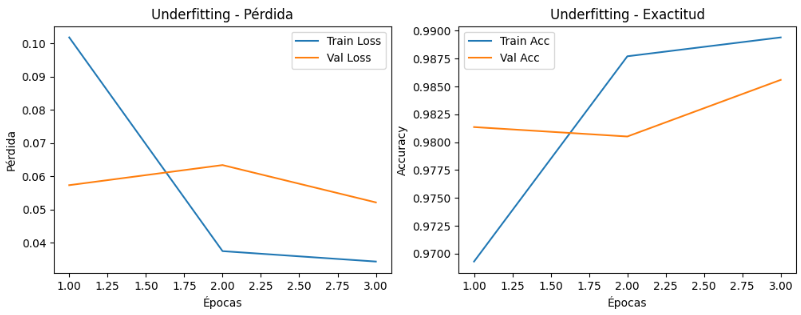

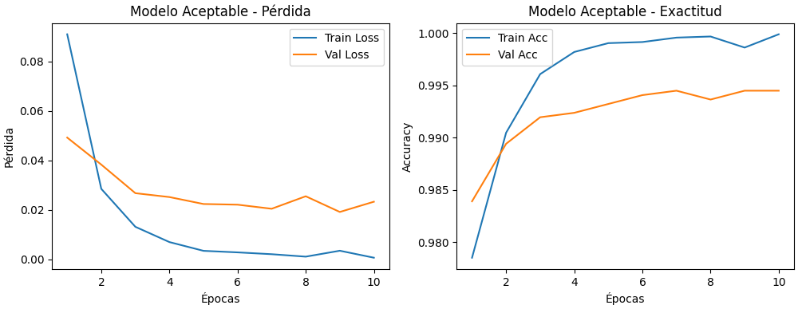

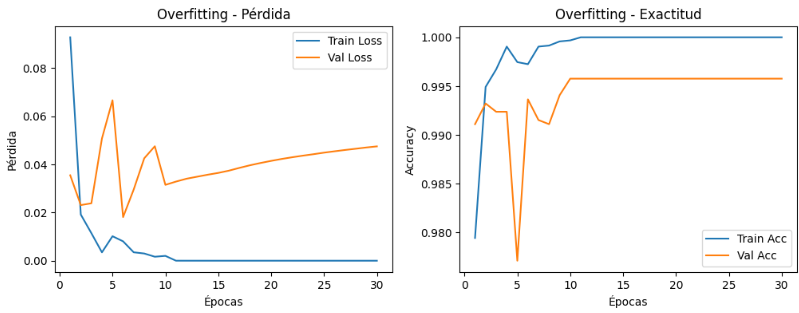

# Función de entrenamiento y evaluación
train_model: entrena la red por un número de épocas, calcula pérdida y accuracy.

evaluate_model: evalúa el desempeño en validación o test.

In [ ]:
def train_model(model, train_loader, val_loader, epochs=5, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.3f} - Val Acc: {val_acc:.3f}")

    return history


def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

### 3.2 Entrene cada modelo.

# Tres configuraciones de entrenamiento
Underfitting: red muy pequeña (1 capa, 5 neuronas, pocas épocas).

Aceptable: red con 2 capas ocultas de 128 neuronas, entrenamiento de 10 épocas.

Overfitting: red grande (4 capas de 512 neuronas) y muchas épocas (30).

### 2.1 Red que subajusta

In [ ]:
# Underfitting
print("\n--- Underfitting ---")
model_under = SimpleNN(input_size=784, hidden_layers=1, hidden_units=5).to(device)
history_under = train_model(model_under, train_loader, val_loader, epochs=3, lr=0.01)


--- Underfitting ---
Epoch 1/3 - Train Acc: 0.976 - Val Acc: 0.985
Epoch 2/3 - Train Acc: 0.987 - Val Acc: 0.989
Epoch 3/3 - Train Acc: 0.991 - Val Acc: 0.989


### 2.2 Red que sobre ajusta

In [ ]:
# Overfitting
print("\n--- Overfitting ---")
model_over = SimpleNN(input_size=784, hidden_layers=4, hidden_units=512).to(device)
history_over = train_model(model_over, train_loader, val_loader, epochs=30, lr=0.001)


--- Overfitting ---
Epoch 1/30 - Train Acc: 0.981 - Val Acc: 0.992
Epoch 2/30 - Train Acc: 0.995 - Val Acc: 0.993
Epoch 3/30 - Train Acc: 0.998 - Val Acc: 0.992
Epoch 4/30 - Train Acc: 0.998 - Val Acc: 0.994
Epoch 5/30 - Train Acc: 0.996 - Val Acc: 0.994
Epoch 6/30 - Train Acc: 0.998 - Val Acc: 0.996
Epoch 7/30 - Train Acc: 0.999 - Val Acc: 0.996
Epoch 8/30 - Train Acc: 1.000 - Val Acc: 0.996
Epoch 9/30 - Train Acc: 1.000 - Val Acc: 0.994
Epoch 10/30 - Train Acc: 0.997 - Val Acc: 0.998
Epoch 11/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 12/30 - Train Acc: 1.000 - Val Acc: 0.996
Epoch 13/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 14/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 15/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 16/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 17/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 18/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 19/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 20/30 - Train Acc: 1.000 - Val Acc: 0.997
Epoch 21/30 - Train Acc: 1.0

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

# Gráficos de entrenamiento

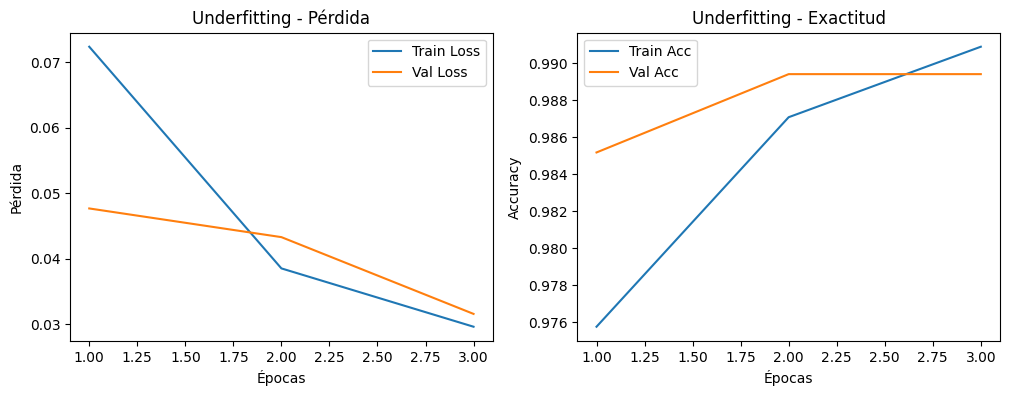

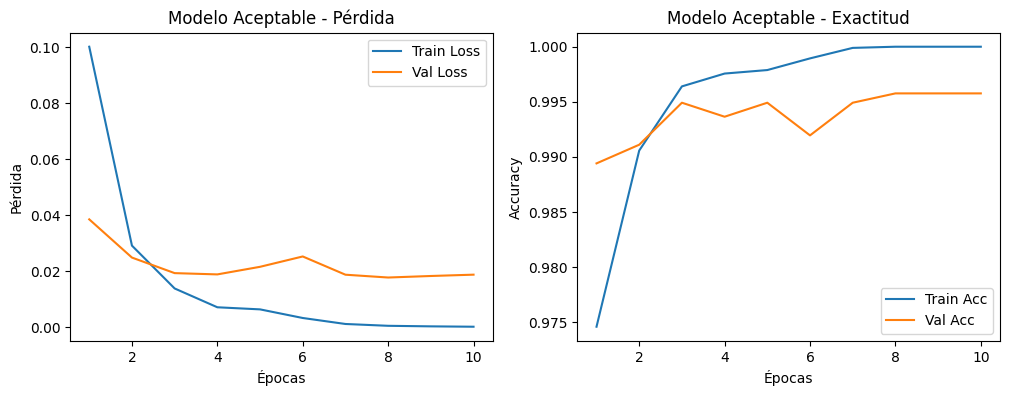

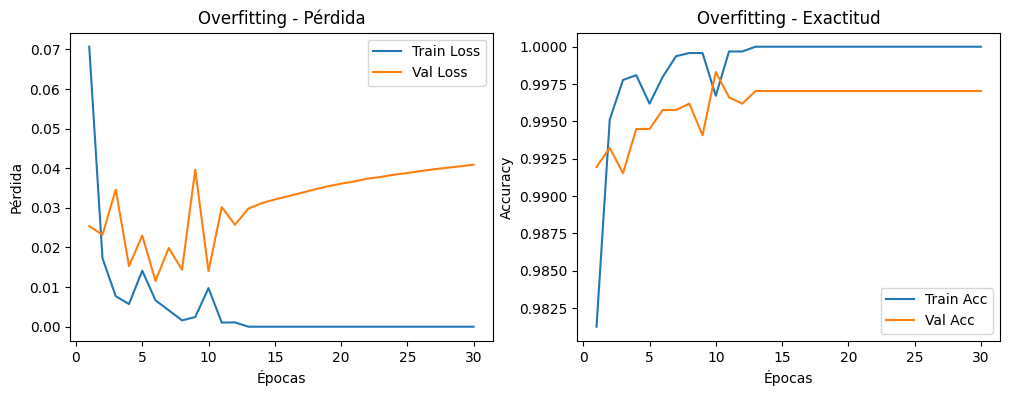

In [ ]:
def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,4))

    # Pérdida
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title(f"{title} - Pérdida")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Exactitud")
    plt.legend()

    plt.show()

# Graficar los tres escenarios
plot_history(history_under, "Underfitting")
plot_history(history_ok, "Modelo Aceptable")
plot_history(history_over, "Overfitting")


## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

Validación: elegir el modelo con mejor métrica de validación (accuracy) — no usar test para elegir.

Simplicidad: si dos modelos tienen métricas similares, escoger el más simple (menos parámetros).

Robustez: preferir modelos con performance estable entre varias inicializaciones / folds.

Regularización / costo: tener en cuenta velocidad y memoria para despliegue.

Procedimiento recomendado (programable):

In [ ]:
# Modelo aceptable
print("\n--- Modelo Aceptable ---")
model_ok = SimpleNN(input_size=784, hidden_layers=2, hidden_units=128).to(device)
history_ok = train_model(model_ok, train_loader, val_loader, epochs=10, lr=0.001)


--- Modelo Aceptable ---
Epoch 1/10 - Train Acc: 0.975 - Val Acc: 0.989
Epoch 2/10 - Train Acc: 0.991 - Val Acc: 0.991
Epoch 3/10 - Train Acc: 0.996 - Val Acc: 0.995
Epoch 4/10 - Train Acc: 0.998 - Val Acc: 0.994
Epoch 5/10 - Train Acc: 0.998 - Val Acc: 0.995
Epoch 6/10 - Train Acc: 0.999 - Val Acc: 0.992
Epoch 7/10 - Train Acc: 1.000 - Val Acc: 0.995
Epoch 8/10 - Train Acc: 1.000 - Val Acc: 0.996
Epoch 9/10 - Train Acc: 1.000 - Val Acc: 0.996
Epoch 10/10 - Train Acc: 1.000 - Val Acc: 0.996


### 2.3 MLP aceptable

# Evaluación final en Test
Evaluamos el accuracy en test usando el modelo aceptable.

Mostramos una matriz de confusión (cuántos 2 y cuántos 4 fueron clasificados bien o mal).

Visualizamos algunos ejemplos mal clasificados para interpretarlo.


Rendimiento final en Test (Modelo Aceptable) - Loss: 0.0274, Accuracy: 0.9940


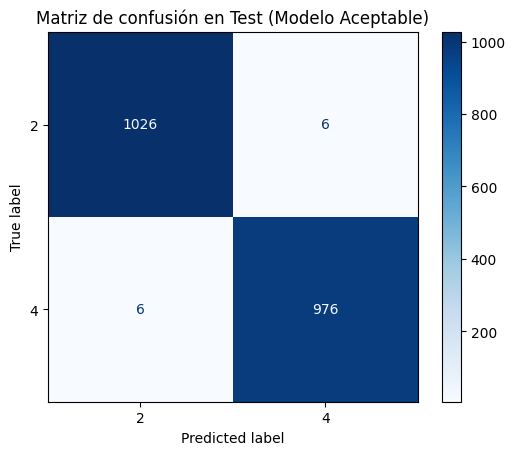

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluación en el conjunto de test
test_loss, test_acc = evaluate_model(model_ok, test_loader, nn.BCELoss())
print(f"\nRendimiento final en Test (Modelo Aceptable) - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# Matriz de confusión
all_preds = []
all_labels = []

model_ok.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model_ok(images).squeeze()
        preds = (outputs >= 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[2,4])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión en Test (Modelo Aceptable)")
plt.show()

# Mostrar algunos errores de clasificación
errors = [(img, lbl, pred) for (img, lbl, pred) in zip(examples, labels, preds) if lbl.item() != pred]

if len(errors) > 0:
    plt.figure(figsize=(10,4))
    for i in range(min(8, len(errors))):
        img, lbl, pred = errors[i]
        plt.subplot(2,4,i+1)
        plt.imshow(img[0].cpu(), cmap="gray")
        plt.title(f"Real: {int(lbl.item())}, Pred: {int(pred)}")
        plt.axis("off")
    plt.show()

*Muestre* y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



# Conclusiones

En el desarrollo de este proyecto se logró comprender el proceso de construcción y entrenamiento de redes neuronales profundas utilizando PyTorch, así como la preparación de un dataset derivado de MNIST para un problema de clasificación binaria. Se adquirieron conocimientos sobre la interpretación de métricas de pérdida y exactitud, lo que permitió identificar los fenómenos de underfitting, overfitting y un modelo con desempeño aceptable. La mayor dificultad se presentó en la selección adecuada de la arquitectura y en el análisis de las curvas de entrenamiento y validación para justificar cada configuración. Como inquietud final, queda el interés de explorar cómo estos conceptos se aplican en conjuntos de datos más complejos, donde las diferencias entre los modelos no resultan tan evidentes.

# Referencias

Goodfellow, Ian; Bengio, Yoshua; Courville, Aaron. Deep Learning. MIT Press.

Bishop, Christopher M. Pattern Recognition and Machine Learning. Springer.

Documentación oficial: PyTorch torch.nn y torch.utils.data.

Scikit-learn: métricas (precision_recall_fscore_support, confusion_matrix).